<h1 align="center"> Auto insurance -  Predicting the total cost & the insurance premium of material claims - Modelling </h1>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, MaxAbsScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, r2_score, mean_squared_error, mean_absolute_error
import scipy.stats
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.svm import SVR
from xgboost import XGBRegressor
from category_encoders import CountEncoder, TargetEncoder
import shap
from sklearn.neural_network import MLPRegressor

## Goal of the project : 
The objective of calculating an annual third-party premium (material + bodily) for the 36,311 contracts in the 2011 pricing dataset :
Indeed, we will determine the cost of third-party insurance for each contract on an annual basis. This premium is intended to cover material and bodily damages caused to third parties in the event of an accident where the insured party is at fault.


#### Step 1. Data cleaning

In [3]:
# Load the training dataset
training_data = pd.read_csv('training_clean.csv')

In [4]:
# Display the first rows of the training dataset to understand its structure
print("Training Dataset:")
training_data.head()

Training Dataset:


,PolNum,CalYear,Gender,Type,Category,Occupation,Age,Group1,Bonus,Poldur,Value,Adind,SubGroup2,Group2,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
0,200114978,2009,Male,C,Large,Employed,25,18,85,3,15080.0,0,L46,L,72.012883,365.0,1,0,0.0,0.0
1,200114994,2009,Male,E,Large,Employed,20,11,30,2,22370.0,1,O38,O,39.550411,365.0,1,0,0.0,0.0
2,200115001,2009,Female,E,Large,Unemployed,42,11,85,0,39650.0,0,Q28,Q,169.529148,365.0,2,0,0.0,0.0
3,200115011,2009,Female,C,Medium,Housewife,21,5,0,0,12600.0,1,L6,L,58.894688,365.0,1,0,0.0,0.0
4,200115015,2009,Female,D,Large,Employed,33,12,30,10,9065.0,0,N4,N,109.631885,365.0,2,0,0.0,0.0


The training dataset contains:

100,000 unique insurance contracts for the years 2009 and 2010e:
Here is a description of each column in the dataset.

| Column     | Description                                                                  |
|------------|------------------------------------------------------------------------------|
| PolNum     | Contract number                                                              |
| CalYear    | Subscription year                                                            |
| Gender     | Gender of the vehicle driver                                                 |
| Type       | Type of car                                                                  |
| Category   | Car category                                                                 |
| Occupation | Driver's occupation                                                          |
| Age        | Driver's age                                                                 |
| Group1     | Car group                                                                    |
| Bonus      | Bonus-Malus (a discount or surcharge applied based on the claims history)   |
| Poldur     | Age of the insurance contract                                                |
| Value      | Value of the insured vehicle                                                 |
| Adind      | Indicator for material coverage                                              |
| SubGroup2  | Driver's home sub-region                                                     |
| Group2     | Driver's home region                                                         |
| Density    | Population density                                                           |
| Expdays    | Exposure (in days)                                                           |
| Numtppd    | Number of third-party material claims                                        |
| Numtpbi    | Number of third-party bodily injury claims                                   |
| Indtppd    | Total cost of third-party material claims                                    |
| Indtpbi    | Total cost of third-party bodily injury claims                               |


In [5]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99979 entries, 0 to 99978
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PolNum      99979 non-null  int64  
 1   CalYear     99979 non-null  int64  
 2   Gender      99979 non-null  object 
 3   Type        99979 non-null  object 
 4   Category    99979 non-null  object 
 5   Occupation  99979 non-null  object 
 6   Age         99979 non-null  int64  
 7   Group1      99979 non-null  int64  
 8   Bonus       99979 non-null  int64  
 9   Poldur      99979 non-null  int64  
 10  Value       99979 non-null  float64
 11  Adind       99979 non-null  int64  
 12  SubGroup2   99979 non-null  object 
 13  Group2      99979 non-null  object 
 14  Density     99979 non-null  float64
 15  Exppdays    99979 non-null  float64
 16  Numtppd     99979 non-null  int64  
 17  Numtpbi     99979 non-null  int64  
 18  Indtppd     99979 non-null  float64
 19  Indtpbi     99979 non-nul

In [6]:
# Check for missing values in the training dataset
print("\nMissing Values in Training Dataset:")
print(training_data.isnull().sum())


Missing Values in Training Dataset:
PolNum        0
CalYear       0
Gender        0
Type          0
Category      0
Occupation    0
Age           0
Group1        0
Bonus         0
Poldur        0
Value         0
Adind         0
SubGroup2     0
Group2        0
Density       0
Exppdays      0
Numtppd       0
Numtpbi       0
Indtppd       0
Indtpbi       0
dtype: int64


In [7]:
# Summary statistics of the training dataset
print("\nSummary Statistics of Training Dataset:")
training_data.describe()


Summary Statistics of Training Dataset:


,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
count,9.997900e+04,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000
mean,2.002003e+08,2009.499935,41.124126,10.691725,-9.374319,5.470579,16358.767416,0.512178,117.142810,349.821137,0.147391,0.046780,106.110750,222.793486
std,6.217119e+04,0.500002,14.301168,4.687371,42.481030,4.591067,10253.792535,0.499854,79.493407,26.019809,0.436855,0.219528,444.979787,1859.763345
min,2.001149e+08,2009.000000,18.000000,1.000000,-50.000000,0.000000,1000.000000,0.000000,14.377142,302.500000,0.000000,0.000000,0.000000,0.000000
25%,2.001399e+08,2009.000000,30.000000,7.000000,-40.000000,1.000000,8380.000000,0.000000,50.566406,340.000000,0.000000,0.000000,0.000000,0.000000
50%,2.001649e+08,2009.000000,40.000000,11.000000,-30.000000,4.000000,14605.000000,1.000000,94.364623,365.000000,0.000000,0.000000,0.000000,0.000000
75%,2.002608e+08,2010.000000,51.000000,14.000000,10.000000,9.000000,22565.000000,1.000000,174.644525,365.000000,0.000000,0.000000,0.000000,0.000000
max,2.002858e+08,2010.000000,75.000000,20.000000,85.000000,15.000000,43842.500000,1.000000,297.385170,365.000000,7.000000,3.000000,12878.369910,69068.026292


In [8]:
# Select only the numeric columns for correlation calculation
numeric_data = training_data.select_dtypes(include='number')

# Calculate the correlation between numeric columns
corr = numeric_data.corr()

# Display the correlation matrix
corr

,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
PolNum,1.000000,0.972664,0.002436,0.004251,-0.005043,-0.003839,-0.003455,0.001786,0.008234,-0.000613,0.016105,0.001248,0.016661,0.007752
CalYear,0.972664,1.000000,0.001772,0.003736,-0.004583,-0.002483,-0.003646,0.001794,0.008792,-0.001321,0.016163,-0.000018,0.017005,0.007686
Age,0.002436,0.001772,1.000000,0.090984,-0.240476,0.050505,0.018009,0.203077,0.003178,0.000702,-0.162977,-0.097232,-0.137944,-0.054483
Group1,0.004251,0.003736,0.090984,1.000000,-0.025149,0.004468,0.233053,0.020499,0.004397,0.003376,0.091433,0.026593,0.059905,0.002923
Bonus,-0.005043,-0.004583,-0.240476,-0.025149,1.000000,-0.009795,-0.004522,-0.048566,-0.004451,-0.000966,0.232109,0.072716,0.140836,0.038668
Poldur,-0.003839,-0.002483,0.050505,0.004468,-0.009795,1.000000,0.002160,0.012514,-0.001126,0.000556,-0.043410,-0.007581,-0.031188,-0.004157
Value,-0.003455,-0.003646,0.018009,0.233053,-0.004522,0.002160,1.000000,0.008062,0.001496,-0.000369,0.023835,0.007678,0.015609,0.001757
Adind,0.001786,0.001794,0.203077,0.020499,-0.048566,0.012514,0.008062,1.000000,0.003238,0.001833,-0.052193,-0.039510,-0.059232,-0.020369
Density,0.008234,0.008792,0.003178,0.004397,-0.004451,-0.001126,0.001496,0.003238,1.000000,-0.002740,0.120872,0.026306,0.105411,0.021309
Exppdays,-0.000613,-0.001321,0.000702,0.003376,-0.000966,0.000556,-0.000369,0.001833,-0.002740,1.000000,0.066077,0.043648,0.047665,0.024760


In [9]:
print("Valeurs uniques de la colonne Numtppd:", training_data['Numtppd'].unique())
print("Valeurs uniques de la colonne Numtpbi:", training_data['Numtpbi'].unique())
print("Valeurs uniques de la colonne Indtppd:", training_data['Indtppd'].unique())
print("Valeurs uniques de la colonne Indtpbi:", training_data['Indtpbi'].unique())
print("Valeurs uniques de la colonne Bonus:", training_data['Bonus'].unique())

Valeurs uniques de la colonne Numtppd: [1 2 0 3 4 5 6 7]
Valeurs uniques de la colonne Numtpbi: [0 1 2 3]
Valeurs uniques de la colonne Indtppd: [   0.          740.30229036  207.32365675 ...  546.40798246  822.92046036
 5800.0189068 ]
Valeurs uniques de la colonne Indtpbi: [0.00000000e+00 3.84004453e+03 2.79371442e+03 ... 3.52825919e+00
 1.05603349e+03 1.65076419e+01]
Valeurs uniques de la colonne Bonus: [ 85  30   0  40  80 -20 -40 -30  20  50 -50 -10  10  70  60]


In [10]:
# Select only numeric columns
numeric_cols = training_data.select_dtypes(include=['number'])

# Calculate the 90th percentile for each numeric column
percentile_90 = numeric_cols.quantile(0.9)

# Count the number of values above the 90th percentile in each column
count_above_90 = (numeric_cols > percentile_90).sum()

# Calculate the percentage of values above the 90th percentile in each column
percentage_above_90 = (count_above_90 / len(numeric_cols)) * 100

# Display the percentages
print("Percentage of values above the 90th percentile in each column:")
print(percentage_above_90)

Percentage of values above the 90th percentile in each column:
PolNum      10.000100
CalYear      0.000000
Age          9.535002
Group1       7.822643
Bonus        8.957881
Poldur       7.146501
Value        9.993099
Adind        0.000000
Density      9.696036
Exppdays     0.000000
Numtppd      1.917403
Numtpbi      4.503946
Indtppd     10.000100
Indtpbi      4.503946
dtype: float64


In [11]:
#Analysis of the categorical variables vs potential target variables : 

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2']
target_variable = 'Indtppd'

# Loop through categorical variables
for var in categorical_vars:
    # Chi-squared test
    table = pd.crosstab(training_data[target_variable], training_data[var])
    chi2_stat, p_value, _, _ = scipy.stats.chi2_contingency(table)
    print(f"Chi-squared test result for {var} and {target_variable}: p-value = {p_value}")
    
    # Cramer's V calculation
    cramer_v = np.sqrt(chi2_stat / len(training_data))
    print(f"Cramer's V for {var} and {target_variable}: {cramer_v}")

Chi-squared test result for Gender and Indtppd: p-value = 0.9999854740534555
Cramer's V for Gender and Indtppd: 0.3406626443450569
Chi-squared test result for Type and Indtppd: p-value = 1.875032137823681e-22
Cramer's V for Type and Indtppd: 0.8043150408995365
Chi-squared test result for Category and Indtppd: p-value = 0.009223793692081771
Cramer's V for Category and Indtppd: 0.5002183398907641
Chi-squared test result for Occupation and Indtppd: p-value = 1.0
Cramer's V for Occupation and Indtppd: 0.6804423712456945
Chi-squared test result for Group2 and Indtppd: p-value = 1.0
Cramer's V for Group2 and Indtppd: 1.0184739098742412


The p-value resulting from the Chi-squared test indicates the statistical significance of the relationship between the target variable and each categorical variable.
And the Cramer's V is as well a statistical measure used to assess the association between categorical variables. Cramer's V ranges from 0 to 1, where 0 indicates no association and 1 indicates a perfect association. It  provides a standardized measure of the strength of association, allowing for easier interpretation and comparison across different studies or datasets.
NB : Group 2 have a strong relationship and at the same time have a high p value which means that the variables can be independent ! 

#### Step 2. Feature engineering (Data pre-processing)

#### Pedicting the Indtppd: 

In [36]:
# List of column names to select
columns_to_select_Ind = ['Gender', 'Type', 'Category', 'Occupation', 'PolNum', 'CalYear', 'Age', 'Adind', 'Density', 'Bonus', 'Exppdays', 'Poldur','Value','Group2']


# Select the columns and assign them to X
X_Ind = training_data[columns_to_select_Ind] # features
y_Ind = training_data["Indtppd"] # target variable

In [37]:
# Identification of missing values
X_Ind.isnull().sum()

Gender        0
Type          0
Category      0
Occupation    0
PolNum        0
CalYear       0
Age           0
Adind         0
Density       0
Bonus         0
Exppdays      0
Poldur        0
Value         0
Group2        0
dtype: int64

In [38]:
# Applying a pipeline on categorical and numerical feature
categorical_features = X_Ind.select_dtypes(include=['object', 'bool']).columns
numerical_features = X_Ind.select_dtypes(exclude=['object', 'bool']).columns

In [39]:
# Handling missing data and normalization of numeric data with MAX Abs Scaler
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Replace missing numeric data by the median
    ("scaler", StandardScaler())])  # Normalization of numeric data after imputing for the missing values

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # Handling missing categorical data



In [40]:
# Define the features preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [41]:
# As our target variable can be imbalanced
X_train_Ind, X_test_Ind, y_train_Ind, y_test_Ind = train_test_split(X_Ind, y_Ind, test_size=0.1, random_state=42)

In [42]:
preprocessor.fit(X_train_Ind, y_train_Ind)
X_train_Ind = preprocessor.transform(X_train_Ind)
X_test_Ind = preprocessor.transform(X_test_Ind)

#### Step 3. Modelling

#### 1. SVR

SVR Regression Metrics (svr_Ind):
Mean Squared Error (svr_Ind): 196082.53411637686
R-squared Score (svr_Ind): -0.05379238565572586
MAE (svr_Ind):
Train_svr_Ind: 106.84891410791462
Test_svr_Ind: 100.22219905552944
MSE (svr_Ind):
Train_svr_Ind: 210705.62547566206
Test_svr_Ind: 196082.53411637686
RMSE (svr_Ind):
Train_svr_Ind: 459.0268243530677
Test_svr_Ind: 442.81207539584653
R2 SCORE (svr_Ind):
Train_svr_Ind: -0.05708833962795712
Test_svr_Ind: -0.05379238565572586
MAPE - Mean Absolute Percentage Error (svr_Ind):
Train_svr_Ind: inf
Test_svr_Ind: inf


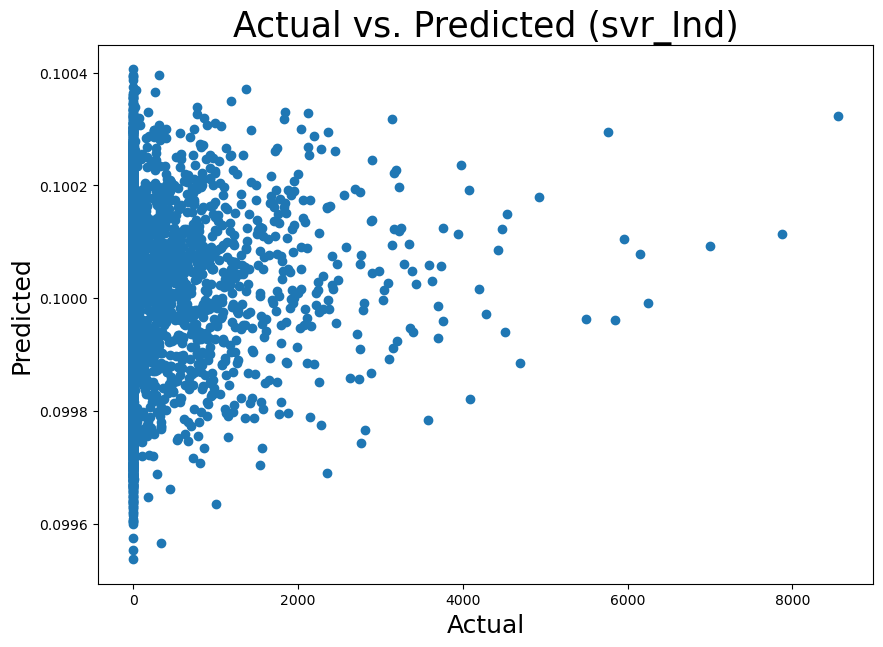

In [50]:
#  Define the SVR model
svr_model = SVR(kernel='linear')

# Train the SVR model
svr_model.fit(X_train_Ind, y_train_Ind)

# Make predictions
y_pred_svr_Ind = svr_model.predict(X_test_Ind)

# Evaluate the model
mse_svr_Ind = mean_squared_error(y_test_Ind, y_pred_svr_Ind)
print("SVR Regression Metrics (svr_Ind):")
print(f"Mean Squared Error (svr_Ind): {mse_svr_Ind}")

r2_svr_Ind = r2_score(y_test_Ind, y_pred_svr_Ind)
print(f"R-squared Score (svr_Ind): {r2_svr_Ind}")

# Predicting on TRAIN & TEST DATA
train_predict_svr_Ind = svr_model.predict(X_train_Ind)
test_predict_svr_Ind = svr_model.predict(X_test_Ind)

# Print MAE (Mean Absolute Error)
print("MAE (svr_Ind):")
print("Train_svr_Ind:", mean_absolute_error(y_train_Ind, train_predict_svr_Ind))
print("Test_svr_Ind:", mean_absolute_error(y_test_Ind, test_predict_svr_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (svr_Ind):")
print("Train_svr_Ind:", mean_squared_error(y_train_Ind, train_predict_svr_Ind))
print("Test_svr_Ind:", mean_squared_error(y_test_Ind, test_predict_svr_Ind))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (svr_Ind):")
print("Train_svr_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_svr_Ind)))
print("Test_svr_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_svr_Ind)))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (svr_Ind):")
print("Train_svr_Ind:", r2_score(y_train_Ind, train_predict_svr_Ind))
print("Test_svr_Ind:", r2_score(y_test_Ind, test_predict_svr_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_svr_Ind = np.mean(np.abs((y_train_Ind - train_predict_svr_Ind) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (svr_Ind):")
print("Train_svr_Ind:", mape_train_svr_Ind)
print("Test_svr_Ind:", np.mean(np.abs((y_test_Ind - test_predict_svr_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (svr_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_svr_Ind)
plt.show()

#### 2. Linear Regression

Intercept (reg_lin): 121.84125096763887
Coefficients (reg_lin): [ 2.67285394e-02  7.09084041e+00 -5.16551464e+01 -1.36953602e+01
  7.18642080e+01  5.15560925e+01  2.09871128e+01 -1.16955623e+01
  7.53134394e+00 -2.15797568e+01  2.15797568e+01 -2.00366601e+00
 -1.64673794e-01 -3.69077931e+00 -2.62964320e+00  4.05542849e+00
  4.43333381e+00  4.77754362e+00 -6.61459837e+00  1.83705475e+00
 -2.31272362e+01 -8.25581335e+00  1.56034576e+01 -2.61014516e+01
  4.18810434e+01 -3.79197881e+00  1.04126596e+01  3.34995677e+01
  2.36225811e+01  2.97485180e+01 -4.27302751e+01 -6.27418009e+01
  1.53652447e+01  1.19629328e+01 -1.53474491e+01]
MAE_reg_lin_Ind:
Train_reg_lin_Ind: 187.0451638435798
Test_reg_lin_Ind: 181.86085513926753
MSE_reg_lin_Ind:
Train_reg_lin_Ind: 188575.19845889567
Test_reg_lin_Ind: 176539.7715674246
RMSE_reg_lin_Ind:
Train_reg_lin_Ind: 434.25245935848847
Test_reg_lin_Ind: 420.16636177521946
R2_SCORE_reg_lin_Ind:
Train_reg_lin_Ind: 0.053937724804828724
Test_reg_lin_Ind: 0.051234890

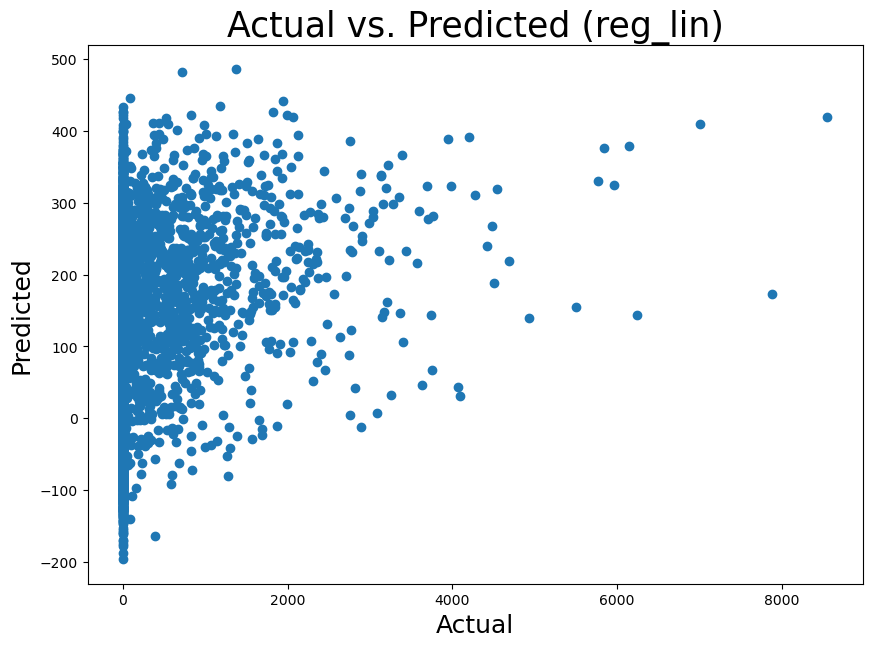

In [51]:
# Instantiate the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train_Ind, y_train_Ind)

# Print intercept and coefficients
print("Intercept (reg_lin):", model.intercept_)
print("Coefficients (reg_lin):", model.coef_)

# Predicting on TRAIN & TEST DATA
train_predict_reg_lin_Ind = model.predict(X_train_Ind)
test_predict_reg_lin_Ind = model.predict(X_test_Ind)

# Print MAE (Mean Absolute Error)
print("MAE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", mean_absolute_error(y_train_Ind, train_predict_reg_lin_Ind))
print("Test_reg_lin_Ind:", mean_absolute_error(y_test_Ind, test_predict_reg_lin_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", mean_squared_error(y_train_Ind, train_predict_reg_lin_Ind))
print("Test_reg_lin_Ind:", mean_squared_error(y_test_Ind, test_predict_reg_lin_Ind))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_reg_lin_Ind)))
print("Test_reg_lin_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_reg_lin_Ind)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", r2_score(y_train_Ind, train_predict_reg_lin_Ind))
print("Test_reg_lin_Ind:", r2_score(y_test_Ind, test_predict_reg_lin_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_reg_lin_Ind, train_predict_reg_lin_Ind = np.array(y_train_Ind), np.array(train_predict_reg_lin_Ind)
mape_train_reg_lin_Ind = np.mean(np.abs((train_y_reg_lin_Ind - train_predict_reg_lin_Ind) / train_y_reg_lin_Ind)) * 100
print("MAPE_reg_lin_Ind - Mean Absolute Percentage Error:")
print("Train_reg_lin_Ind:", mape_train_reg_lin_Ind)
print("Test_reg_lin_Ind:", np.mean(np.abs((np.array(y_test_Ind) - np.array(test_predict_reg_lin_Ind)) / np.array(y_test_Ind))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (reg_lin)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_reg_lin_Ind)
plt.show()

#### 3. Polynomial Features

Polynomial Regression Metrics (poly_Ind):
Mean Squared Error (poly_Ind): 176828.7512273286
R-squared Score (poly_Ind): 0.049681847248187805
Intercept (poly_Ind): 228204058493424.0
Coefficients (poly_Ind): [-3.00531720e+10 -3.60955445e+13  5.90065054e+13 ...  0.00000000e+00
  0.00000000e+00  1.65952897e+13]
MAE (poly_Ind):
Train_poly_Ind: 180.7892978192485
Test_poly_Ind: 184.28225607280964
MSE (poly_Ind):
Train_poly_Ind: 173561.87415830052
Test_poly_Ind: 176828.7512273286
RMSE (poly_Ind):
Train_poly_Ind: 416.60757813354826
Test_poly_Ind: 420.51010835332914
R2 SCORE (poly_Ind):
Train_poly_Ind: 0.1292580206981404
Test_poly_Ind: 0.049681847248187805
MAPE - Mean Absolute Percentage Error (poly_Ind):
Train_poly_Ind: inf
Test_poly_Ind: inf


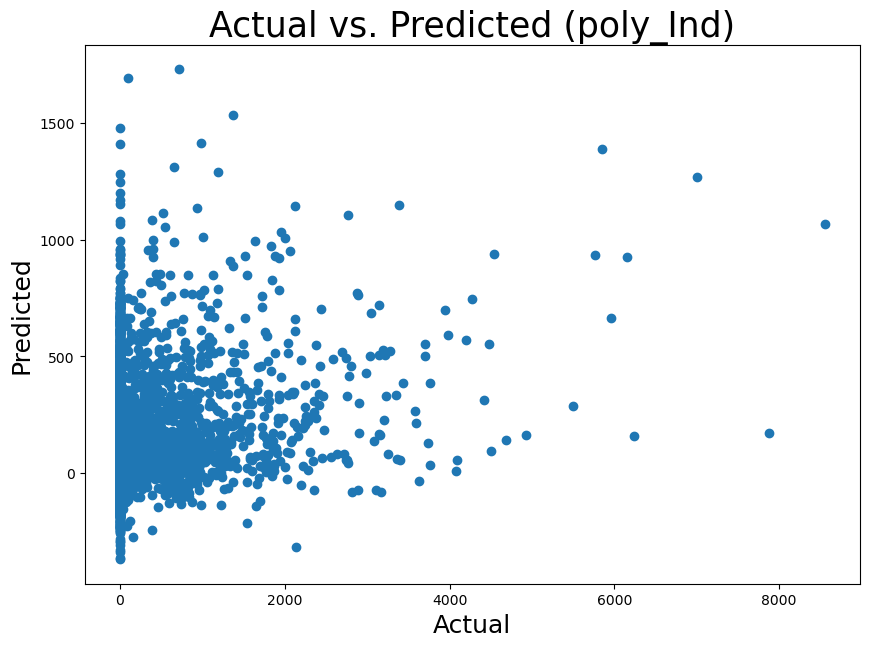

In [52]:
# Define the polynomial regression model
degree = 3  # Degree of the polynomial
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Train the polynomial regression model
poly_model.fit(X_train_Ind, y_train_Ind)

# Make predictions
y_pred_poly_Ind = poly_model.predict(X_test_Ind)

# Evaluate the model
mse_poly_Ind = mean_squared_error(y_test_Ind, y_pred_poly_Ind)
print("Polynomial Regression Metrics (poly_Ind):")
print(f"Mean Squared Error (poly_Ind): {mse_poly_Ind}")

r2_poly_Ind = r2_score(y_test_Ind, y_pred_poly_Ind)
print(f"R-squared Score (poly_Ind): {r2_poly_Ind}")

# Calculate other metrics
print("Intercept (poly_Ind):", poly_model.named_steps['linearregression'].intercept_)
print("Coefficients (poly_Ind):", poly_model.named_steps['linearregression'].coef_)

# Predicting on TRAIN & TEST DATA
train_predict_poly_Ind = poly_model.predict(X_train_Ind)
test_predict_poly_Ind = poly_model.predict(X_test_Ind)

# Print MAE (Mean Absolute Error)
print("MAE (poly_Ind):")
print("Train_poly_Ind:", mean_absolute_error(y_train_Ind, train_predict_poly_Ind))
print("Test_poly_Ind:", mean_absolute_error(y_test_Ind, test_predict_poly_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (poly_Ind):")
print("Train_poly_Ind:", mean_squared_error(y_train_Ind, train_predict_poly_Ind))
print("Test_poly_Ind:", mean_squared_error(y_test_Ind, test_predict_poly_Ind))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (poly_Ind):")
print("Train_poly_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_poly_Ind)))
print("Test_poly_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_poly_Ind)))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (poly_Ind):")
print("Train_poly_Ind:", r2_score(y_train_Ind, train_predict_poly_Ind))
print("Test_poly_Ind:", r2_score(y_test_Ind, test_predict_poly_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_poly_Ind = np.mean(np.abs((y_train_Ind - train_predict_poly_Ind) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (poly_Ind):")
print("Train_poly_Ind:", mape_train_poly_Ind)
print("Test_poly_Ind:", np.mean(np.abs((y_test_Ind - test_predict_poly_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (poly_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_poly_Ind)
plt.show()

#### 4. RandomForest with Grid search

Random Forest Regression Metrics (with GridSearchCV) (RF_GSCV_Ind_ppd):
Mean Squared Error (RF_GSCV_Ind_ppd): 85727.27851450977
R-squared Score (RF_GSCV_Ind_ppd): 0.5392819980184407
Best parameters found by GridSearchCV (RF_GSCV_Ind_ppd):
{'regressor__max_depth': 5, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 1000}
MAE (RF_GSCV_Ind_ppd):
Train_RF_GSCV_Ind_ppd: 72.53978215711174
Test_RF_GSCV_Ind_ppd: 71.8070476610734
MSE (RF_GSCV_Ind_ppd):
Train_RF_GSCV_Ind_ppd: 89238.58801846094
Test_RF_GSCV_Ind_ppd: 85727.27851450977
RMSE (RF_GSCV_Ind_ppd):
Train_RF_GSCV_Ind_ppd: 298.7282845973259
Test_RF_GSCV_Ind_ppd: 292.79221047444173
R2 SCORE (RF_GSCV_Ind_ppd):
Train_RF_GSCV_Ind_ppd: 0.5522992296659195
Test_RF_GSCV_Ind_ppd: 0.5392819980184407
MAPE - Mean Absolute Percentage Error (RF_GSCV_Ind_ppd):
Train_RF_GSCV_Ind_ppd: inf
Test_RF_GSCV_Ind_ppd: 670.6966945865521


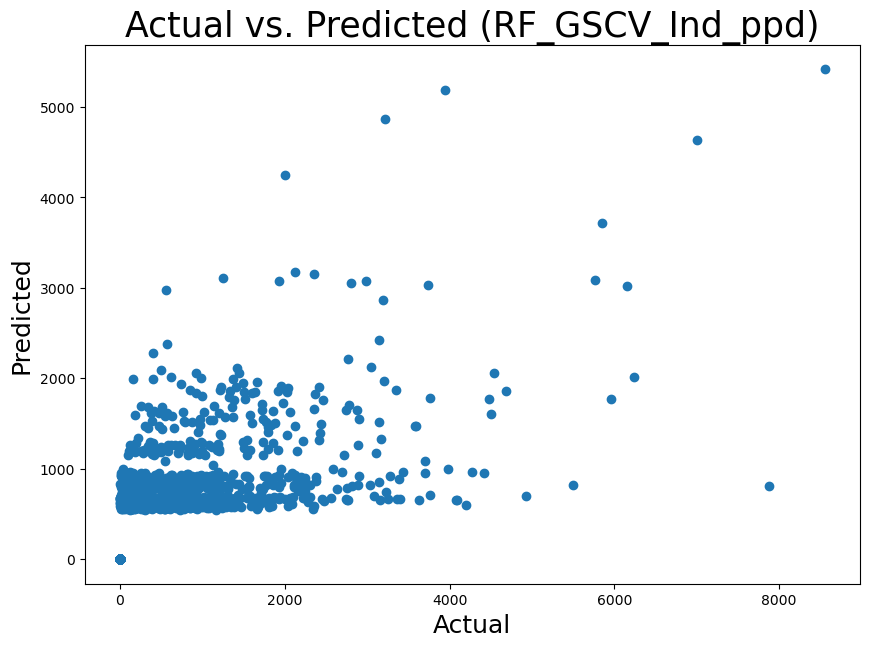

In [41]:
# Define the parameter grid for GridSearchCV
param_grid_RF_GSCV_ppd = {
    'regressor__n_estimators': [1000, 20, 30],  # Number of trees in the forest
    'regressor__max_depth': [None, 5],  # Maximum depth of the tree
    'regressor__min_samples_split': [2, 10],  # Minimum number of samples required to split a node
    'regressor__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Define the Random Forest regression model for GridSearchCV
rf_model_RF_GSCV_ppd = RandomForestRegressor(random_state=42)

# Create Pipeline for Random Forest with preprocessing and GridSearchCV
pipeline_RF_GSCV_ppd = Pipeline([
    ('preprocessor', preprocessor),  # Preprocessing steps
    ('regressor', rf_model_RF_GSCV_ppd)  # Random Forest regressor
])

# Configuration et exécution de la recherche sur grille
grid_search_RF_GSCV_ppd = GridSearchCV(estimator=pipeline_RF_GSCV_ppd, param_grid=param_grid_RF_GSCV_ppd, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_RF_GSCV_ppd.fit(X_train_Ind, y_train_Ind)

best_rf_model_RF_GSCV_ppd = grid_search_RF_GSCV_ppd.best_estimator_

# Make predictions
y_pred_rf_grid_Ind_ppd = best_rf_model_RF_GSCV_ppd.predict(X_test_Ind)

# Evaluate the model
mse_rf_grid_Ind_ppd = mean_squared_error(y_test_Ind, y_pred_rf_grid_Ind_ppd)
print("Random Forest Regression Metrics (with GridSearchCV) (RF_GSCV_Ind_ppd):")
print(f"Mean Squared Error (RF_GSCV_Ind_ppd): {mse_rf_grid_Ind_ppd}")

r2_rf_grid_Ind_ppd = r2_score(y_test_Ind, y_pred_rf_grid_Ind_ppd)
print(f"R-squared Score (RF_GSCV_Ind_ppd): {r2_rf_grid_Ind_ppd}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV (RF_GSCV_Ind_ppd):")
print(grid_search_RF_GSCV_ppd.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE (RF_GSCV_Ind_ppd):")
print("Train_RF_GSCV_Ind_ppd:", mean_absolute_error(y_train_Ind, best_rf_model_RF_GSCV_ppd.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind_ppd:", mean_absolute_error(y_test_Ind, y_pred_rf_grid_Ind_ppd))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (RF_GSCV_Ind_ppd):")
print("Train_RF_GSCV_Ind_ppd:", mean_squared_error(y_train_Ind, best_rf_model_RF_GSCV_ppd.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind_ppd:", mse_rf_grid_Ind_ppd)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (RF_GSCV_Ind_ppd):")
print("Train_RF_GSCV_Ind_ppd:", np.sqrt(mean_squared_error(y_train_Ind, best_rf_model_RF_GSCV_ppd.predict(X_train_Ind))))
print("Test_RF_GSCV_Ind_ppd:", np.sqrt(mse_rf_grid_Ind_ppd))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (RF_GSCV_Ind_ppd):")
print("Train_RF_GSCV_Ind_ppd:", r2_score(y_train_Ind, best_rf_model_RF_GSCV_ppd.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind_ppd:", r2_rf_grid_Ind_ppd)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_rf_Ind_ppd = np.mean(np.abs((y_train_Ind - best_rf_model_RF_GSCV_ppd.predict(X_train_Ind)) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (RF_GSCV_Ind_ppd):")
print("Train_RF_GSCV_Ind_ppd:", mape_train_rf_Ind_ppd)
print("Test_RF_GSCV_Ind_ppd:", np.mean(np.abs((y_test_Ind - y_pred_rf_grid_Ind_ppd) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (RF_GSCV_Ind_ppd)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=y_pred_rf_grid_Ind_ppd)
plt.show()

Random Forest Regression Metrics (with GridSearchCV) (RF_GSCV_Ind):
Mean Squared Error (RF_GSCV_Ind): 170460.42097577816
R-squared Score (RF_GSCV_Ind): 0.08390671056233623
Best parameters found by GridSearchCV (RF_GSCV_Ind):
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1000}
MAE (RF_GSCV_Ind):
Train_RF_GSCV_Ind: 171.45638510671483
Test_RF_GSCV_Ind: 167.4114241133604
MSE (RF_GSCV_Ind):
Train_RF_GSCV_Ind: 181337.4529752756
Test_RF_GSCV_Ind: 170460.42097577816
RMSE (RF_GSCV_Ind):
Train_RF_GSCV_Ind: 425.83735507265635
Test_RF_GSCV_Ind: 412.8685274706443
R2 SCORE (RF_GSCV_Ind):
Train_RF_GSCV_Ind: 0.09024874563618002
Test_RF_GSCV_Ind: 0.08390671056233623
MAPE - Mean Absolute Percentage Error (RF_GSCV_Ind):
Train_RF_GSCV_Ind: inf
Test_RF_GSCV_Ind: inf


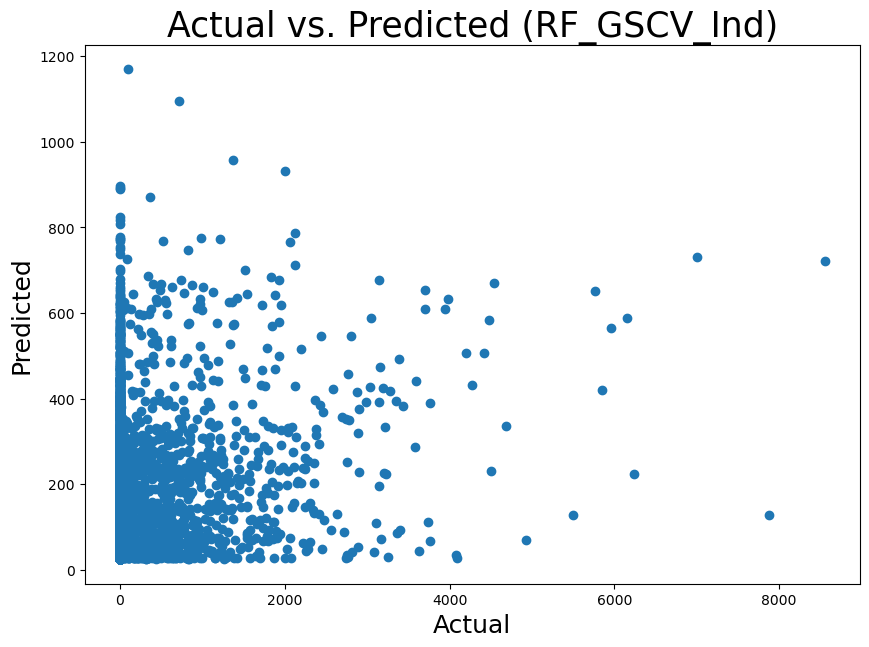

In [22]:
# Define the parameter grid for GridSearchCV
param_grid_RF_GSCV = {
    'n_estimators': [1000, 20, 30],  # Number of trees in the forest
    'max_depth': [None, 5],  # Maximum depth of the tree
    'min_samples_split': [2, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2]  # Minimum number of samples required at each leaf node
}

# Define the Random Forest regression model for GridSearchCV
rf_model_RF_GSCV = RandomForestRegressor(random_state=42)

# Create GridSearchCV object for Random Forest
grid_search_RF_GSCV = GridSearchCV(estimator=rf_model_RF_GSCV, param_grid=param_grid_RF_GSCV, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search_RF_GSCV.fit(X_train_Ind, y_train_Ind)

# Get the best model
best_rf_model_RF_GSCV = grid_search_RF_GSCV.best_estimator_

# Make predictions
y_pred_rf_grid_Ind = best_rf_model_RF_GSCV.predict(X_test_Ind)

# Evaluate the model
mse_rf_grid_Ind = mean_squared_error(y_test_Ind, y_pred_rf_grid_Ind)
print("Random Forest Regression Metrics (with GridSearchCV) (RF_GSCV_Ind):")
print(f"Mean Squared Error (RF_GSCV_Ind): {mse_rf_grid_Ind}")

r2_rf_grid_Ind = r2_score(y_test_Ind, y_pred_rf_grid_Ind)
print(f"R-squared Score (RF_GSCV_Ind): {r2_rf_grid_Ind}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV (RF_GSCV_Ind):")
print(grid_search_RF_GSCV.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", mean_absolute_error(y_train_Ind, best_rf_model_RF_GSCV.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind:", mean_absolute_error(y_test_Ind, y_pred_rf_grid_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", mean_squared_error(y_train_Ind, best_rf_model_RF_GSCV.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind:", mse_rf_grid_Ind)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", np.sqrt(mean_squared_error(y_train_Ind, best_rf_model_RF_GSCV.predict(X_train_Ind))))
print("Test_RF_GSCV_Ind:", np.sqrt(mse_rf_grid_Ind))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", r2_score(y_train_Ind, best_rf_model_RF_GSCV.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind:", r2_rf_grid_Ind)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_rf_Ind = np.mean(np.abs((y_train_Ind - best_rf_model_RF_GSCV.predict(X_train_Ind)) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", mape_train_rf_Ind)
print("Test_RF_GSCV_Ind:", np.mean(np.abs((y_test_Ind - y_pred_rf_grid_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (RF_GSCV_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=y_pred_rf_grid_Ind)
plt.show()

#### 5. XGBoost with GridSearch

XGBoost Regression Metrics (with GridSearchCV) - xgb_GSCV_Ind:
Mean Squared Error (xgb_GSCV_Ind): 167860.51881301572
R-squared Score (xgb_GSCV_Ind): 0.09787917942558977
Best parameters found by GridSearchCV:
{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 700}
MAE (xgb_GSCV_Ind):
Train_Ind: 166.75621090881953
Test_Ind: 164.14175665596264
MSE (xgb_GSCV_Ind):
Train_Ind: 173969.8018918075
Test_Ind: 167860.51881301572
RMSE (xgb_GSCV_Ind):
Train_Ind: 417.09687350998865
Test_Ind: 409.7078456815487
R2 SCORE (xgb_GSCV_Ind):
Train_Ind: 0.12721148943193605
Test_Ind: 0.09787917942558977
MAPE - Mean Absolute Percentage Error (xgb_GSCV_Ind):
Train_Ind: inf
Test_Ind: inf


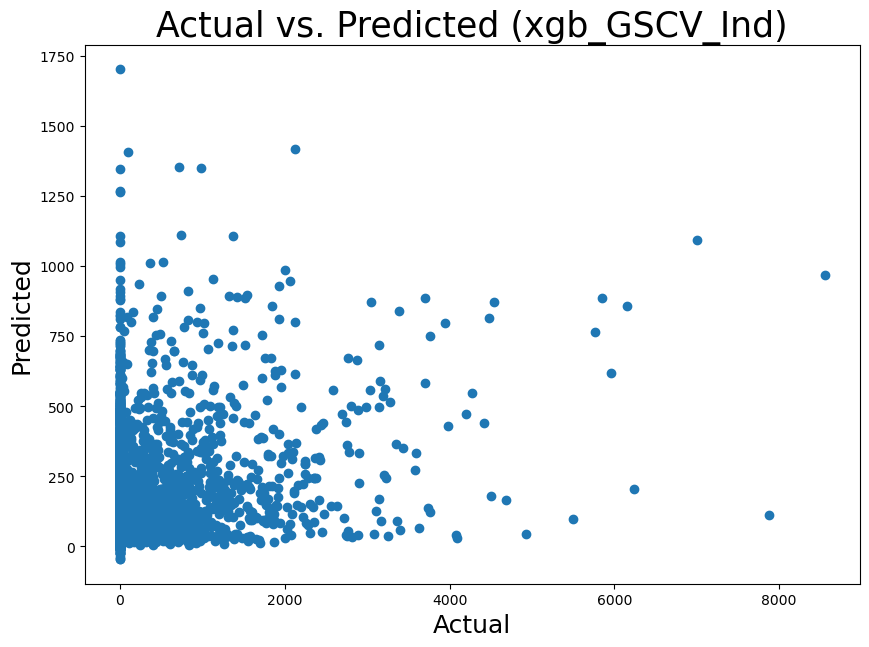

In [32]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators':  [700, 800, 900],  # Number of boosting rounds
    'max_depth': [2, 4, 6], # Maximum depth of the tree
    'learning_rate': [0.01, 0.02, 0.03]  # Step size shrinkage used in update to prevents overfitting
}

# Define the XGBoost regression model
xgb_model = XGBRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_Ind, y_train_Ind)

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Make predictions
y_pred_xgb_grid_Ind = best_xgb_model.predict(X_test_Ind)

# Evaluate the model
mse_xgb_grid_Ind = mean_squared_error(y_test_Ind, y_pred_xgb_grid_Ind)
print("XGBoost Regression Metrics (with GridSearchCV) - xgb_GSCV_Ind:")
print(f"Mean Squared Error (xgb_GSCV_Ind): {mse_xgb_grid_Ind}")

r2_xgb_grid_Ind = r2_score(y_test_Ind, y_pred_xgb_grid_Ind)
print(f"R-squared Score (xgb_GSCV_Ind): {r2_xgb_grid_Ind}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE (xgb_GSCV_Ind):")
print("Train_Ind:", mean_absolute_error(y_train_Ind, best_xgb_model.predict(X_train_Ind)))
print("Test_Ind:", mean_absolute_error(y_test_Ind, y_pred_xgb_grid_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (xgb_GSCV_Ind):")
print("Train_Ind:", mean_squared_error(y_train_Ind, best_xgb_model.predict(X_train_Ind)))
print("Test_Ind:", mse_xgb_grid_Ind)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (xgb_GSCV_Ind):")
print("Train_Ind:", np.sqrt(mean_squared_error(y_train_Ind, best_xgb_model.predict(X_train_Ind))))
print("Test_Ind:", np.sqrt(mse_xgb_grid_Ind))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (xgb_GSCV_Ind):")
print("Train_Ind:", r2_score(y_train_Ind, best_xgb_model.predict(X_train_Ind)))
print("Test_Ind:", r2_xgb_grid_Ind)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_xgb_Ind = np.mean(np.abs((y_train_Ind - best_xgb_model.predict(X_train_Ind)) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (xgb_GSCV_Ind):")
print("Train_Ind:", mape_train_xgb_Ind)
print("Test_Ind:", np.mean(np.abs((y_test_Ind - y_pred_xgb_grid_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (xgb_GSCV_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=y_pred_xgb_grid_Ind)
plt.show()


#### 6. MLP regressor

MAE (MLP_Ind):
Train_MLP_Ind: 163.18372736438533
Test_MLP_Ind: 169.43044639338143
MSE (MLP_Ind):
Train_MLP_Ind: 162205.69050951803
Test_MLP_Ind: 179376.19395196045
RMSE (MLP_Ind):
Train_MLP_Ind: 402.7476759827647
Test_MLP_Ind: 423.5282681852068
R2 SCORE (MLP_Ind):
Train_MLP_Ind: 0.18623082002754532
Test_MLP_Ind: 0.035991307403788086
MAPE - Mean Absolute Percentage Error (MLP_Ind):
Train_MLP_Ind: inf
Test_MLP_Ind: inf


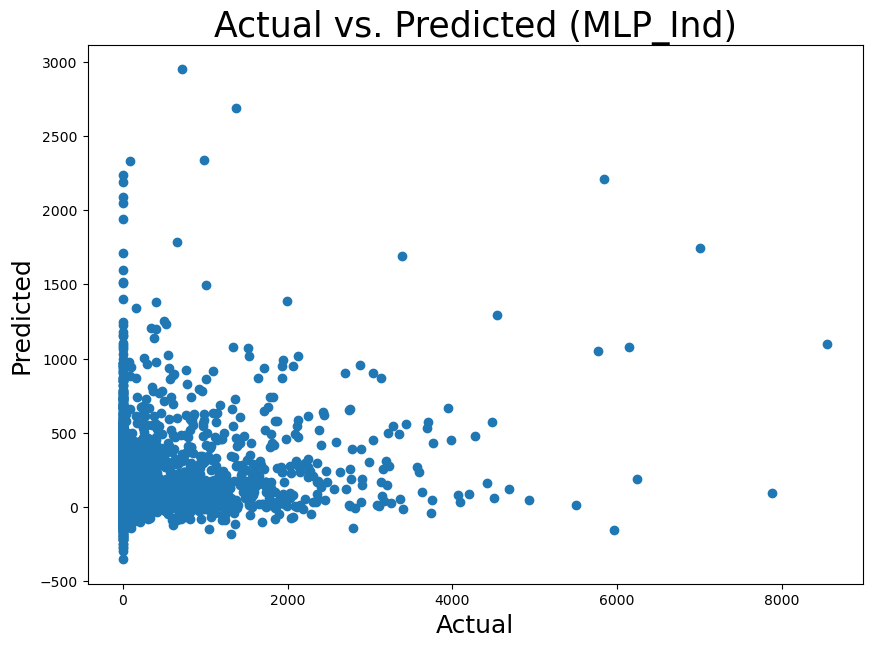

In [53]:
# Define the MLP regressor
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', 
                             alpha=0.0001, batch_size='auto', learning_rate='constant', 
                             learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
                             random_state=42, tol=0.0001, verbose=False, warm_start=False, 
                             momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
                             validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                             n_iter_no_change=10, max_fun=15000)

# Fit the MLP regressor
mlp_regressor.fit(X_train_Ind, y_train_Ind)

# Make predictions
train_predict_mlp_Ind = mlp_regressor.predict(X_train_Ind)
test_predict_mlp_Ind = mlp_regressor.predict(X_test_Ind)

# Print evaluation metrics
print("MAE (MLP_Ind):")
print("Train_MLP_Ind:", mean_absolute_error(y_train_Ind, train_predict_mlp_Ind))
print("Test_MLP_Ind:", mean_absolute_error(y_test_Ind, test_predict_mlp_Ind))
print("====================================")

print("MSE (MLP_Ind):")
print("Train_MLP_Ind:", mean_squared_error(y_train_Ind, train_predict_mlp_Ind))
print("Test_MLP_Ind:", mean_squared_error(y_test_Ind, test_predict_mlp_Ind))
print("====================================")

print("RMSE (MLP_Ind):")
print("Train_MLP_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_mlp_Ind)))
print("Test_MLP_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_mlp_Ind)))
print("====================================")

print("R2 SCORE (MLP_Ind):")
print("Train_MLP_Ind:", r2_score(y_train_Ind, train_predict_mlp_Ind))
print("Test_MLP_Ind:", r2_score(y_test_Ind, test_predict_mlp_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_mlp_Ind = np.mean(np.abs((y_train_Ind - train_predict_mlp_Ind) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (MLP_Ind):")
print("Train_MLP_Ind:", mape_train_mlp_Ind)
print("Test_MLP_Ind:", np.mean(np.abs((y_test_Ind - test_predict_mlp_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (MLP_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_mlp_Ind)
plt.show()

#### Step 4. Interpretability

In [56]:
# List of model names
model_names = ['SVR', 'Linear Regression', 'Polynomial Regression', 'Random Forest With GridSearch', 'XGBoost With GridSearch', 'MLP Regressor']

# List of predicted values for each model
all_y_pred = [test_predict_svr_Ind, test_predict_reg_lin_Ind, test_predict_poly_Ind, y_pred_rf_grid_Ind, y_pred_xgb_grid_Ind, test_predict_mlp_Ind]

# List of metrics for each model
all_metrics = {
    'Model': model_names,
    'MAE': [mean_absolute_error(y_test_Ind, y_pred) for y_pred in all_y_pred],
    'MSE': [mean_squared_error(y_test_Ind, y_pred) for y_pred in all_y_pred],
    'RMSE': [np.sqrt(mean_squared_error(y_test_Ind, y_pred)) for y_pred in all_y_pred],
    'R2': [r2_score(y_test_Ind, y_pred) for y_pred in all_y_pred]
}

# Creating DataFrames
df_predictions = pd.DataFrame({f'y_pred_{model}': y_pred.flatten() for model, y_pred in zip(model_names, all_y_pred)})
df_metrics = pd.DataFrame(all_metrics)

# Display the DataFrames
print("\nPredictions DataFrame:")
(df_predictions)



Predictions DataFrame:


,y_pred_SVR,y_pred_Linear Regression,y_pred_Polynomial Regression,y_pred_Random Forest With GridSearch,y_pred_XGBoost With GridSearch,y_pred_MLP Regressor
0,0.100065,300.673153,673.15625,306.423793,429.774078,823.895975
1,0.099886,17.256505,38.43750,67.839426,37.723351,57.075060
2,0.099882,72.044731,129.78125,27.498883,30.493954,58.672626
3,0.099940,38.364142,46.31250,27.298271,30.608040,-43.346803
4,0.100027,222.926132,155.18750,224.309921,294.684082,110.988409
...,...,...,...,...,...,...
9993,0.099773,266.665654,447.12500,353.892890,507.446808,497.973853
9994,0.099849,113.262629,87.50000,66.154083,66.037834,113.392103
9995,0.099917,-78.947974,-15.00000,27.255228,27.079956,19.266541
9996,0.099885,218.741486,143.81250,335.456893,166.377457,119.039041


In [57]:
print("\nMetrics DataFrame:")
df_metrics


Metrics DataFrame:


,Model,MAE,MSE,RMSE,R2
0,SVR,100.222199,196082.534116,442.812075,-0.053792
1,Linear Regression,181.860855,176539.771567,420.166362,0.051235
2,Polynomial Regression,184.282256,176828.751227,420.510108,0.049682
3,Random Forest With GridSearch,167.411424,170460.420976,412.868527,0.083907
4,XGBoost With GridSearch,164.141757,167860.518813,409.707846,0.097879
5,MLP Regressor,169.430446,179376.193952,423.528268,0.035991


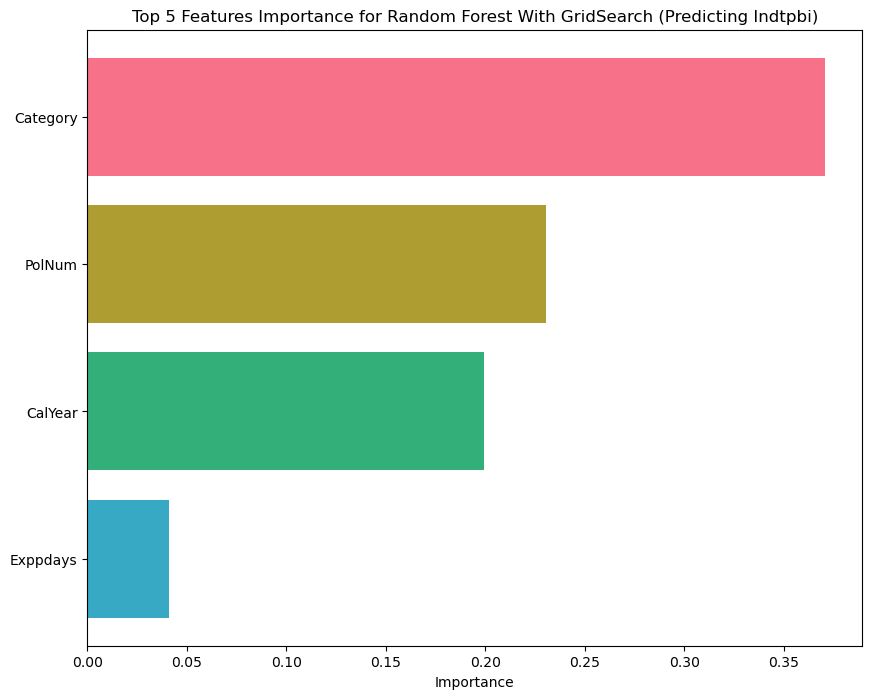

In [28]:
# Retrieve the best estimator
best_rf_model_RF_GSCV = grid_search_RF_GSCV.best_estimator_
feature_importances = best_rf_model_RF_GSCV.feature_importances_

# List of feature names
feature_names =  ['Gender', 'Type', 'Category', 'Occupation', 'PolNum', 'CalYear', 'Age', 'Adind', 'Density', 'Bonus', 'Exppdays', 'Poldur','Value','Group2']

# Sort the features by their importance
sorted_idx = np.argsort(feature_importances)

# Select the top 5 most important features
top_5_idx = sorted_idx[-5:]

# Check the length of top_5_idx
if len(top_5_idx) > len(feature_names):
    # If it exceeds, select only the valid indices
    top_5_valid_idx = top_5_idx[-len(feature_names):]
else:
    top_5_valid_idx = top_5_idx

# Check if any of the selected indices exceed the length of feature_names
top_5_valid_idx = [idx for idx in top_5_valid_idx if idx < len(feature_names)]

# Define your custom color palette
custom_palette = sns.color_palette("husl", 5) 

# Create the plot with the valid indices
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_5_valid_idx)), feature_importances[top_5_valid_idx][::-1], color=custom_palette)
plt.yticks(range(len(top_5_valid_idx)), np.array(feature_names)[top_5_valid_idx][::-1])  # Reverse the order for display
plt.xlabel('Importance')
plt.title('Top 5 Features Importance for Random Forest With GridSearch (Predicting Indtpbi)')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()


In [31]:
# Create a DataFrame of SHAP values with feature names
shap_df = pd.DataFrame(shap_values, columns=X_Ind_encoded.columns)

# Display the DataFrame
shap_df.head()

,PolNum,CalYear,Age,Adind,Density,Bonus,Exppdays,Poldur,Value,Gender_Female,...,Group2_L,Group2_M,Group2_N,Group2_O,Group2_P,Group2_Q,Group2_R,Group2_S,Group2_T,Group2_U
0,253.548107,0.001624,-68.906330,-0.932468,284.444101,341.568082,11.774804,-1.381537,11.067834,1.400002,...,0.008020,-0.713613,-0.104166,-0.000339,-0.000425,4.754796,-0.502150,-0.000050,-0.000318,-0.009365
1,254.710213,0.001624,-68.811304,-0.932468,285.284768,342.912863,11.772607,-1.433651,11.034469,1.397190,...,-0.001657,-0.713613,-0.103454,0.004286,-0.000425,4.754796,-0.502150,-0.000050,-0.000318,-0.009365
2,242.782516,0.009663,-73.058325,-0.813489,278.818887,339.328618,12.034754,-2.749473,10.104185,-2.008911,...,-0.001683,-0.596241,-0.106055,-0.000354,-0.000425,-7.693871,-0.502150,0.000054,-0.000523,-0.009365
3,42.402981,0.000251,-51.539330,-0.101027,90.680588,-52.111049,3.138849,-0.479064,7.053976,-1.961046,...,0.009499,-0.242018,-0.078154,-0.000166,-0.000701,0.306058,-0.018243,0.000024,-0.000229,-0.006891
4,252.415416,0.001624,-50.946188,-0.932941,282.491924,341.573514,11.832843,-1.588899,11.936615,-2.058722,...,-0.001683,-0.630735,1.156089,-0.000354,-0.000425,4.762012,-0.502150,0.000054,-0.000523,-0.009365


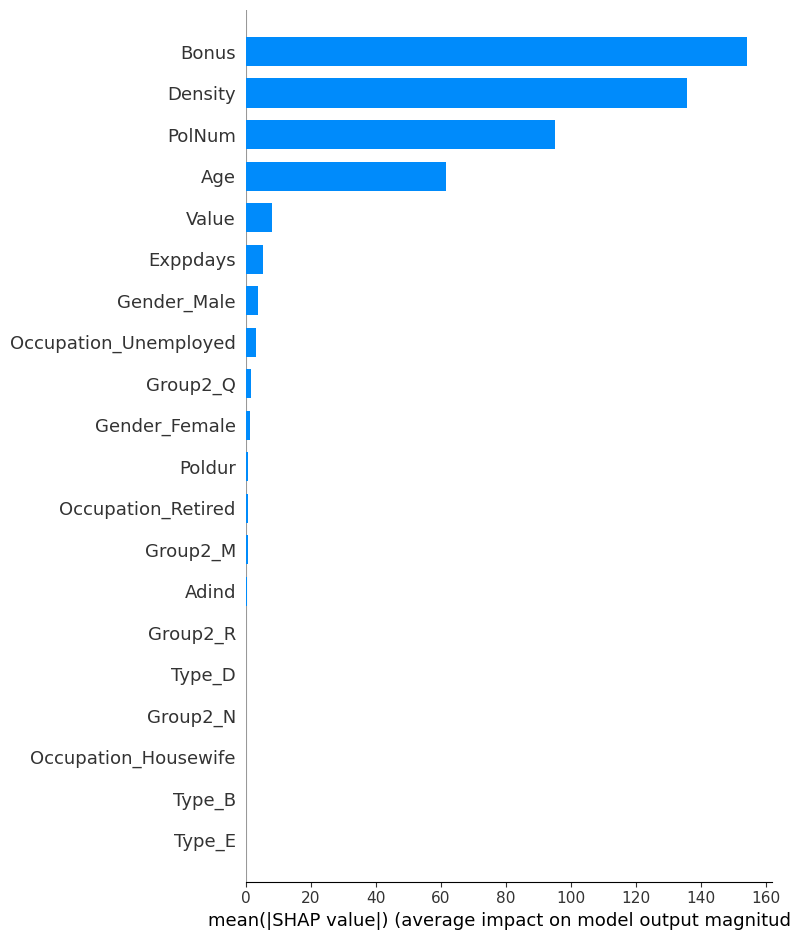

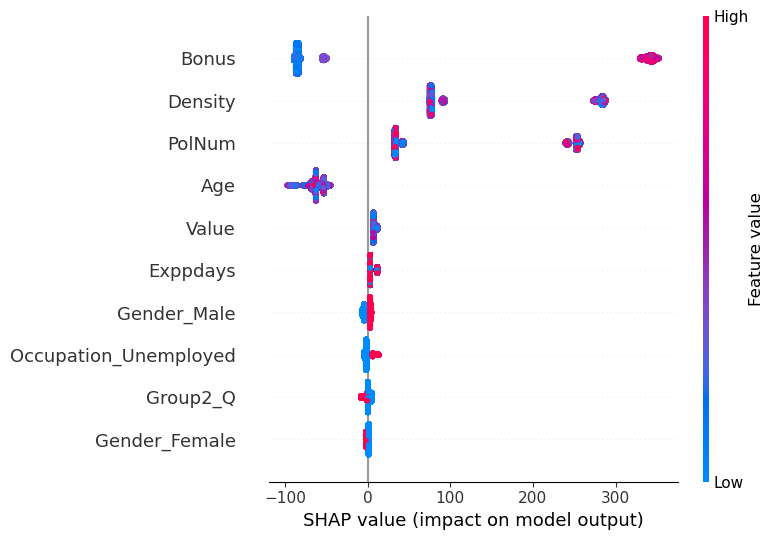

In [62]:
# One-hot encode categorical features
X_Ind_encoded = pd.get_dummies(X_Ind)

# Convert DataFrame to NumPy array
X_Ind_encoded_array = X_Ind_encoded.values

# Create a SHAP explainer
explainer = shap.TreeExplainer(best_rf_model_RF_GSCV )

# Calculate SHAP values
shap_values = explainer.shap_values(X_Ind_encoded_array)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_Ind_encoded_array, plot_type="bar", feature_names=X_Ind_encoded.columns)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_Ind_encoded_array, feature_names=X_Ind_encoded.columns,max_display=10)

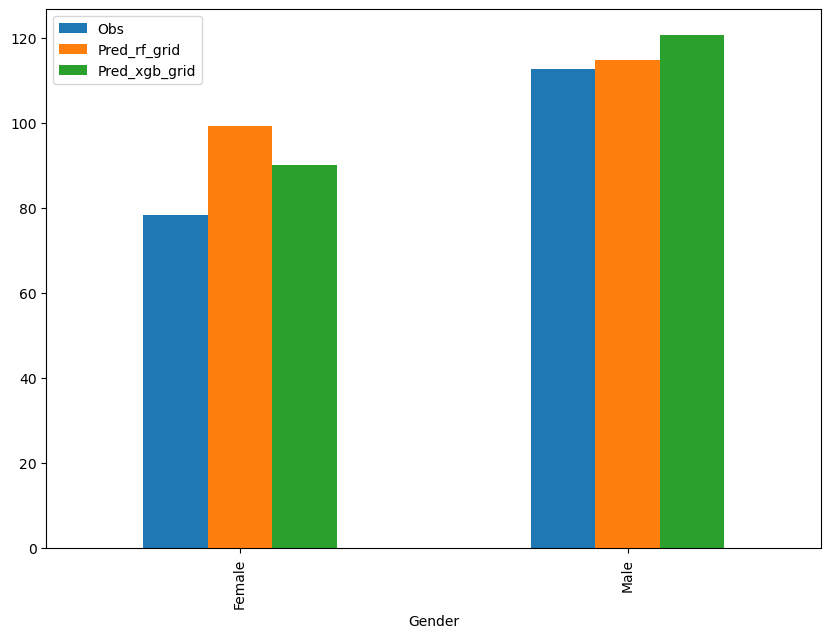

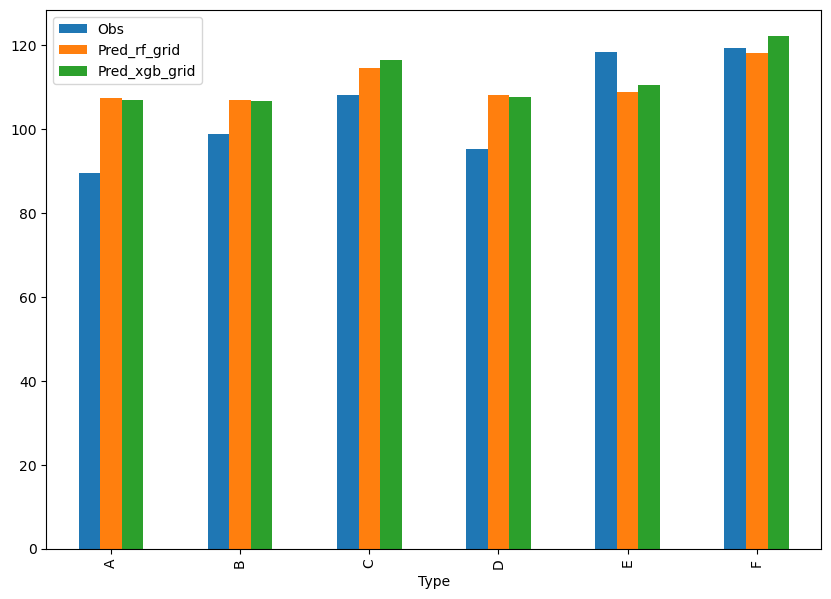

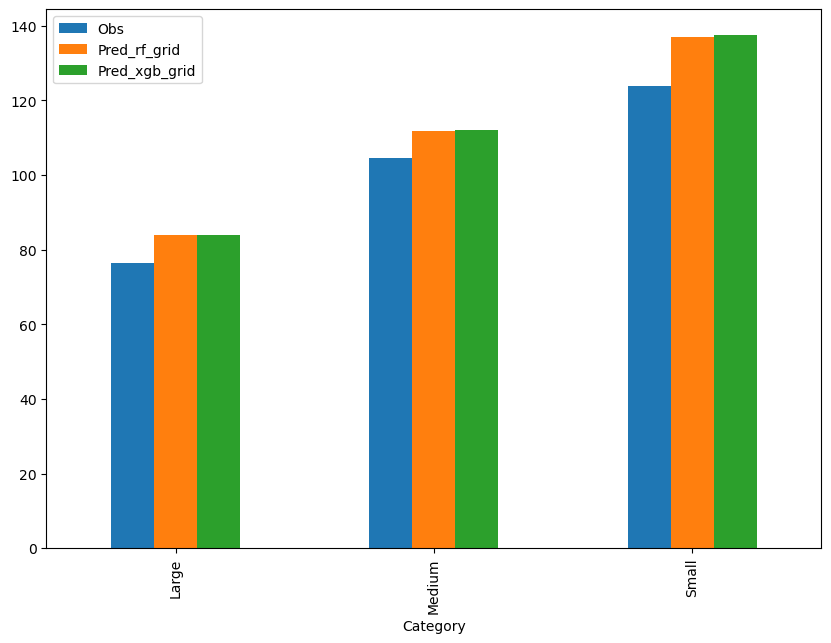

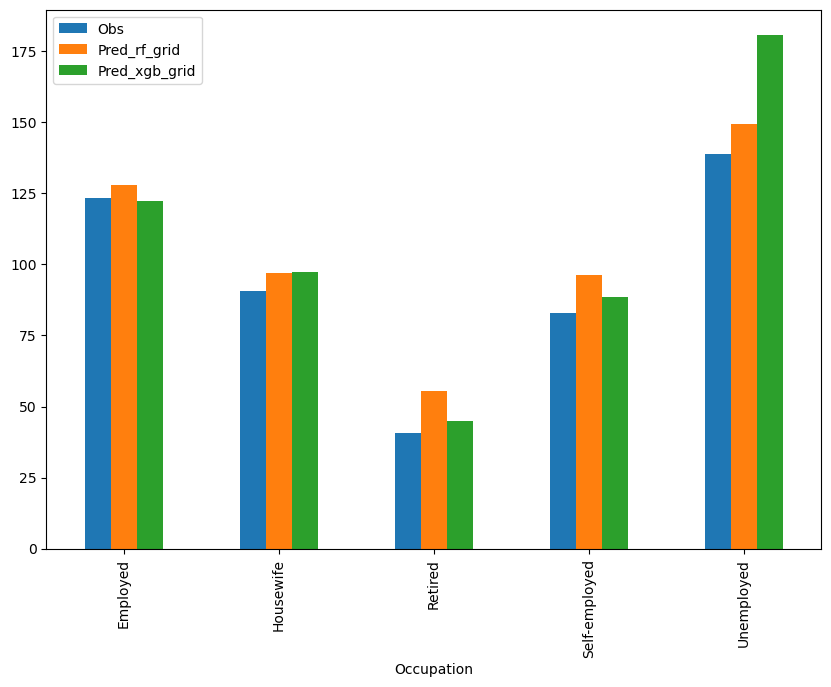

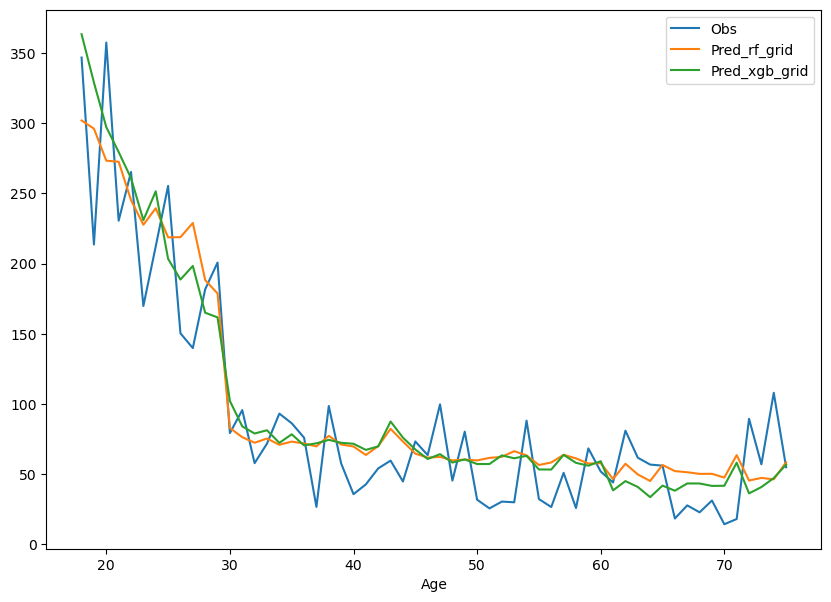

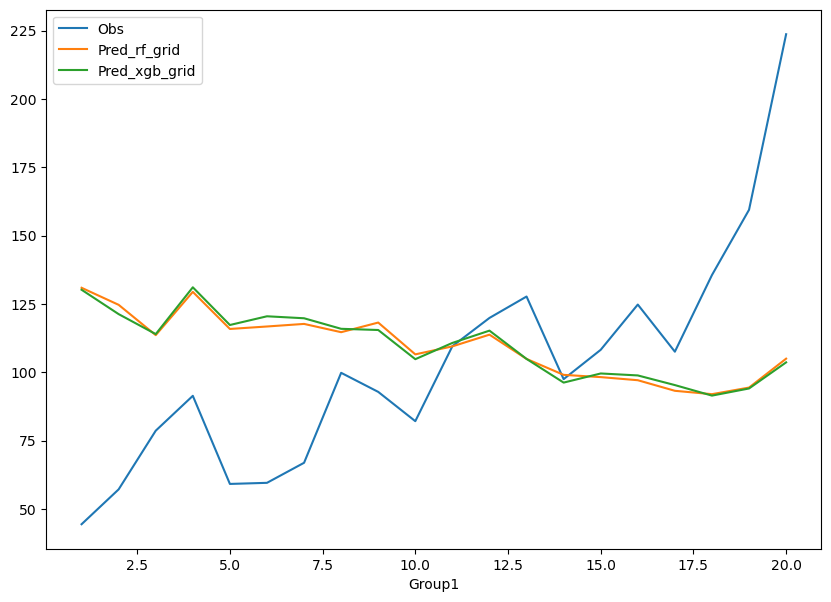

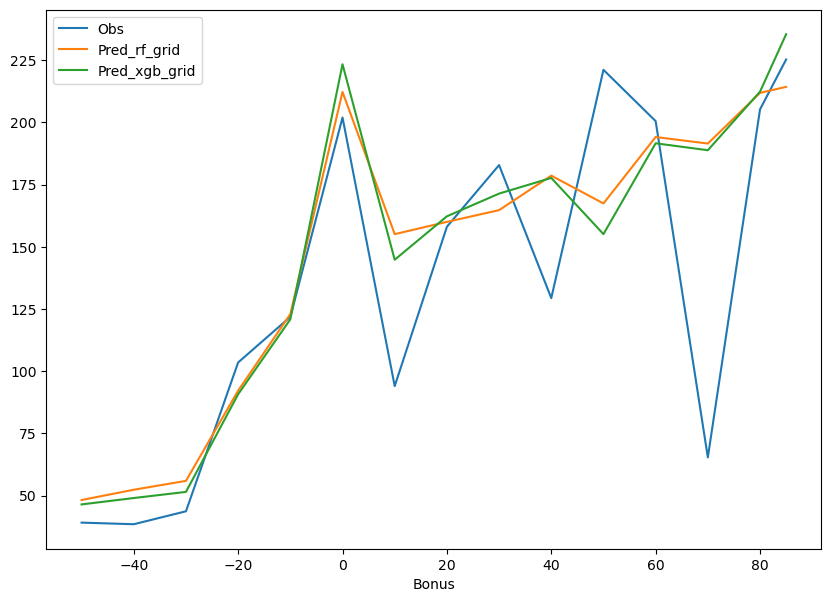

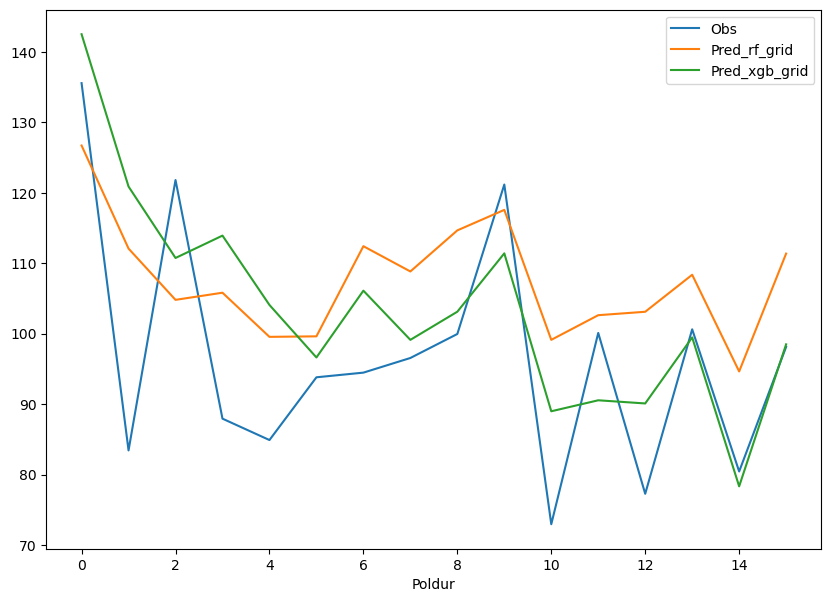

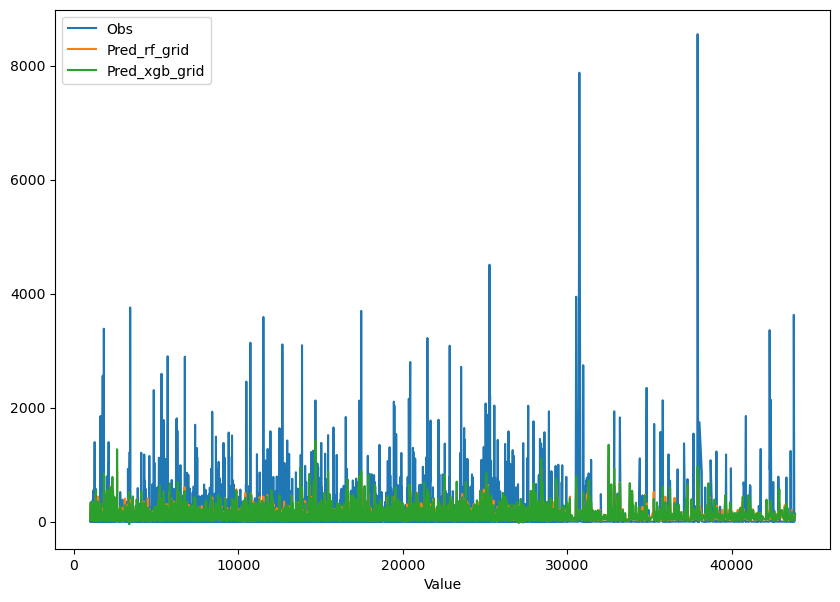

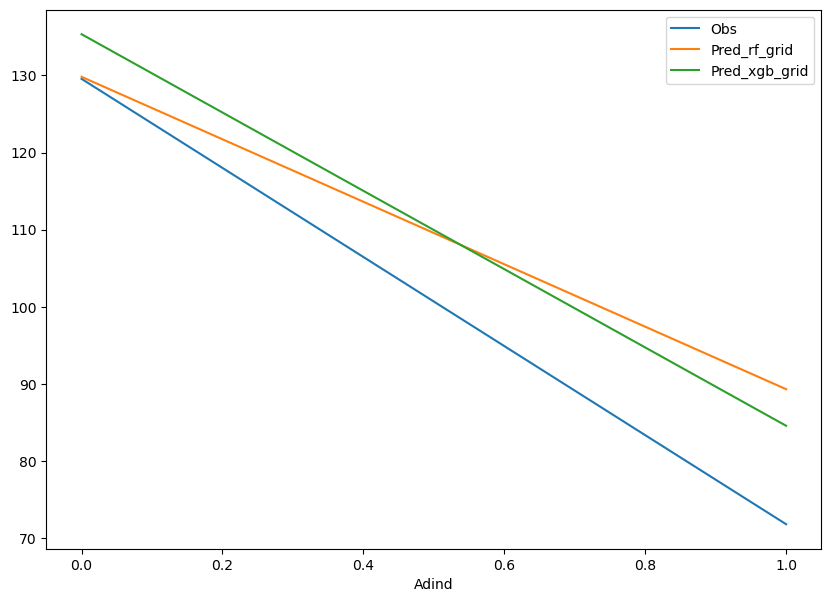

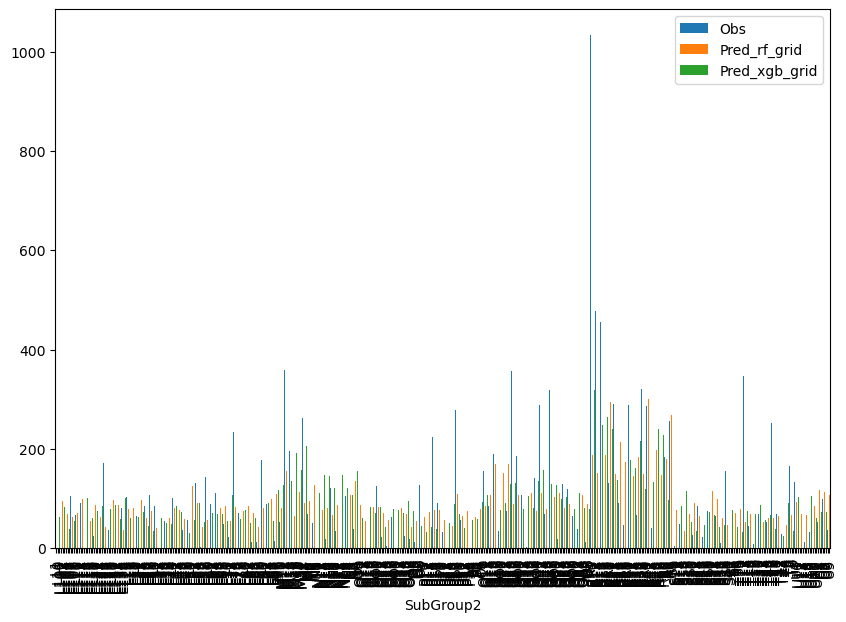

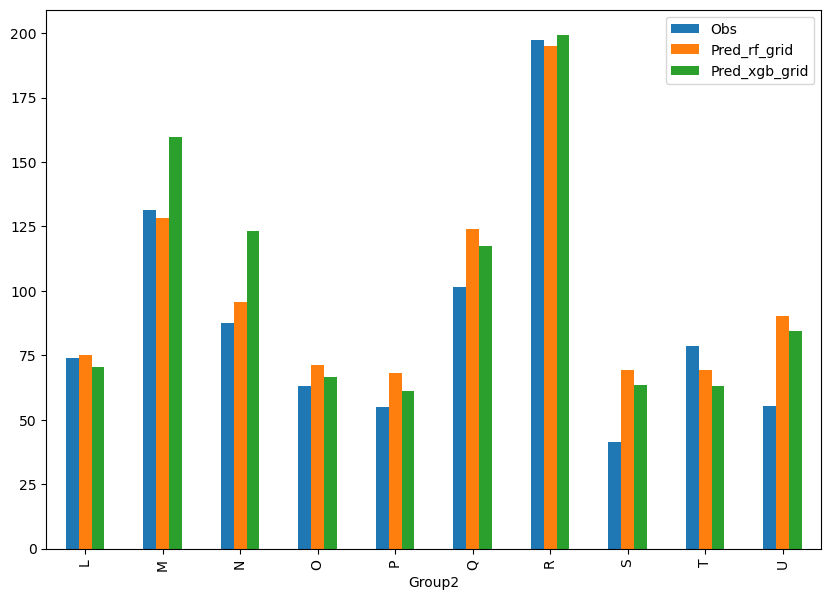

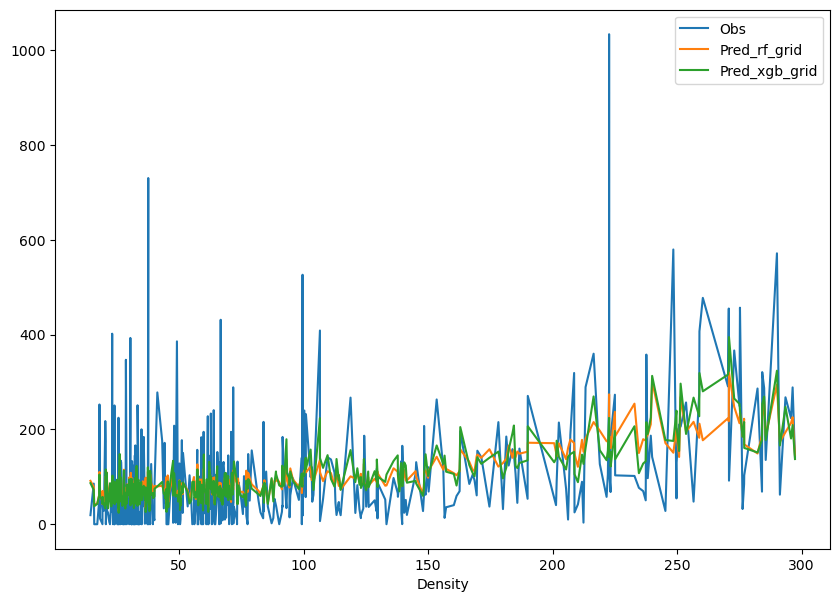

In [34]:
#Impact of target variable on the remaining variables
dataProv = pd.DataFrame(y_test_Ind.index)
dataProv.columns = ['index']
dataProv['Obs'] = np.array(y_test_Ind)
dataProv['Pred_rf_grid'] = y_pred_rf_grid_Ind
dataProv['Pred_xgb_grid'] = y_pred_xgb_grid_Ind
# dataProv['Pred_xgb_grid'] = p_xgb_grid
dataProv.head()

dataFinale = training_data.copy().reset_index().merge(dataProv)
dataFinale.head()
palette = "deep"

for var in dataFinale.columns[3:16]:
    dataPlot = dataFinale.groupby([var])[['Obs', 'Pred_rf_grid', 'Pred_xgb_grid']].mean()
    
    if dataFinale[var].dtypes == 'O':
        # Créer un graphique à barres avec des couleurs de la palette
        ax = dataPlot.plot(kind='bar', figsize=(10, 7))
        ax.set_prop_cycle(color=sns.color_palette(palette))
    else:
        # Créer un graphique linéaire avec des couleurs de la palette
        ax = dataPlot.plot(figsize=(10, 7))
        ax.set_prop_cycle(color=sns.color_palette(palette))

plt.show()